In [1]:
import json
import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import silhouette_score
import warnings
warnings.filterwarnings("ignore")

In [2]:
def jsonl_to_dataframe(file_path):
    #logging.info(f"Loading JSONL file from {file_path}...")
    data = []
    with open(file_path, 'r') as file:
        for line in file:
            record = json.loads(line)
            if 'time_series' in record:
                time_series_data = record.pop('time_series')
                record.update(time_series_data)
            data.append(record)
    df = pd.DataFrame(data)
    
    #logging.info("Available columns in DataFrame: %s", df.columns)
    return df

def is_nested(column):
    return column.apply(lambda x: isinstance(x, (list, dict))).any()

# Function to apply PCA
def apply_pca(cluster_data, n_components=2):
    pca = PCA(n_components=n_components)
    principal_components = pca.fit_transform(cluster_data)
    explained_variance = pca.explained_variance_ratio_
    print(f"Explained variance by each component: {explained_variance}")
    return principal_components

In [3]:
time_file_path = r'D:\MENG-Project\bearings-project-meng\Streamlit\outputs\Gold\time_domain_features.jsonl'
freq_file_path = r'D:\MENG-Project\bearings-project-meng\Streamlit\outputs\Gold\frequency_domain_features.jsonl'
hybrid_file_path = r'D:\MENG-Project\bearings-project-meng\Streamlit\outputs\Gold\time_frequency_features.jsonl'

data1 = jsonl_to_dataframe(time_file_path)
data2 = jsonl_to_dataframe(freq_file_path)
data3 = jsonl_to_dataframe(hybrid_file_path)

raw_data1 = data1.loc[:, ~data1.apply(is_nested)]
raw_data2 = data2.loc[:, ~data2.apply(is_nested)]
raw_data3 = data3.loc[:, ~data3.apply(is_nested)]

time_cluster = raw_data1.drop(columns=['identifier','timestamp','channel_x_anomalies','channel_y_anomalies'])
freq_cluster = raw_data2.drop(columns=['identifier','timestamp','channel_x_anomalies','channel_y_anomalies'])
hybrid_cluster = raw_data3.drop(columns=['identifier','timestamp','channel_x_anomalies','channel_y_anomalies'])

In [16]:
merge_data1 = raw_data1.merge(raw_data2, on = 'timestamp')
merge_data = merge_data1.merge(raw_data3, on = 'timestamp')
drop_substrings = ['identifier', 'channel_x_anomalies', 'channel_y_anomalies']

# Drop columns containing any of the specified substrings
merge_cluster = merge_data.loc[:, ~merge_data.columns.str.contains('|'.join(drop_substrings))]

# Assigning labels 1-4 for each 25% of the data
merge_cluster['label'] = pd.qcut(merge_cluster.index, q=4, labels=[1, 2, 3, 4])

merge_cluster = merge_cluster.drop(columns=['bearing','split','bearing_x','split_x'])

X = merge_cluster.drop(columns = ['label'],axis = 1)
y = merge_cluster['label']

In [5]:
merge_cluster

,channel_x_mean,channel_x_median,channel_x_std,channel_x_var,channel_x_skew,channel_x_kurtosis,channel_x_rms,channel_x_ptp,channel_x_crest_factor,channel_x_energy,...,channel_y_cepstrum_mean,channel_y_cepstrum_std,channel_y_cepstrum_max,channel_x_stft_mean,channel_x_stft_std,channel_x_stft_max,channel_y_stft_mean,channel_y_stft_std,channel_y_stft_max,label
0,-6.941605e-19,-0.002227,1.0,1.0,-0.003932,-0.130810,1.0,6.716630,3.572381,2559.0,...,0.034623,0.191122,6.762974,0.046089,0.058460,0.556137,0.060467,0.043136,0.267726,1
1,1.457737e-17,0.008098,1.0,1.0,-0.026098,-0.085607,1.0,6.801451,3.588824,2559.0,...,0.034842,0.192759,6.834750,0.046488,0.057514,0.441948,0.061284,0.041968,0.264842,1
2,-1.388321e-17,-0.003984,1.0,1.0,-0.004590,0.032538,1.0,6.921668,3.586234,2559.0,...,0.035517,0.191268,6.778841,0.046646,0.058451,0.678223,0.059592,0.044076,0.382845,1
3,-4.060839e-17,0.017655,1.0,1.0,-0.080295,0.042283,1.0,6.826001,3.438594,2559.0,...,0.035130,0.192413,6.819198,0.046451,0.057919,0.523891,0.060664,0.042820,0.294622,1
4,6.247445e-18,0.016547,1.0,1.0,-0.034972,-0.184929,1.0,6.047700,3.122457,2559.0,...,0.034343,0.192049,6.816997,0.045781,0.057772,0.572739,0.061953,0.041537,0.306738,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2804,1.908942e-17,-0.018747,1.0,1.0,-0.517395,12.163215,1.0,13.780588,7.163878,2559.0,...,0.034807,0.182846,6.410798,0.037117,0.066250,0.673828,0.051129,0.056082,0.500750,4
2805,3.470803e-18,0.001371,1.0,1.0,0.037530,9.353590,1.0,12.729662,6.424563,2559.0,...,0.034018,0.185932,6.531156,0.043251,0.063243,0.592516,0.052822,0.053985,0.493437,4
2806,9.371167e-18,-0.011422,1.0,1.0,-0.271513,7.048794,1.0,13.410018,7.561061,2559.0,...,0.034384,0.184660,6.477565,0.042456,0.061144,0.611734,0.053197,0.053205,0.441803,4
2807,-4.338503e-18,-0.004342,1.0,1.0,-0.352551,10.922391,1.0,13.276351,6.929013,2559.0,...,0.034411,0.184029,6.474742,0.037411,0.060200,0.571897,0.051013,0.051025,0.441443,4


In [6]:
#X_pca = apply_pca(X)

X_train, X_test, y_train, y_test = train_test_split(X,y,stratify=y,test_size=0.3,random_state=22)

print(X_train.shape,y_train.shape, X_test.shape)

(1966, 42) (1966,) (843, 42)


In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

# List of models to evaluate
models = {
    "Logistic Regression": LogisticRegression(),
    "Random Forest": RandomForestClassifier(),
    "Support Vector Machine": SVC(),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
}

# Train and evaluate each model
results = {}

for model_name, model in models.items():
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    results[model_name] = accuracy

# Print the results
print("Model Evaluation Results:")
for model_name, accuracy in results.items():
    print(f"{model_name}: {accuracy:.4f}")

Model Evaluation Results:
Logistic Regression: 0.6904
Random Forest: 0.9098
Support Vector Machine: 0.2871
K-Nearest Neighbors: 0.6180
Decision Tree: 0.8671


In [12]:
merge_cluster

,timestamp,channel_x_mean,channel_x_median,channel_x_std,channel_x_var,channel_x_skew,channel_x_kurtosis,channel_x_rms,channel_x_ptp,channel_x_crest_factor,...,channel_y_cepstrum_mean,channel_y_cepstrum_std,channel_y_cepstrum_max,channel_x_stft_mean,channel_x_stft_std,channel_x_stft_max,channel_y_stft_mean,channel_y_stft_std,channel_y_stft_max,label
0,9:39:39,-6.941605e-19,-0.002227,1.0,1.0,-0.003932,-0.130810,1.0,6.716630,3.572381,...,0.034623,0.191122,6.762974,0.046089,0.058460,0.556137,0.060467,0.043136,0.267726,1
1,9:39:49,1.457737e-17,0.008098,1.0,1.0,-0.026098,-0.085607,1.0,6.801451,3.588824,...,0.034842,0.192759,6.834750,0.046488,0.057514,0.441948,0.061284,0.041968,0.264842,1
2,9:39:59,-1.388321e-17,-0.003984,1.0,1.0,-0.004590,0.032538,1.0,6.921668,3.586234,...,0.035517,0.191268,6.778841,0.046646,0.058451,0.678223,0.059592,0.044076,0.382845,1
3,9:40:9,-4.060839e-17,0.017655,1.0,1.0,-0.080295,0.042283,1.0,6.826001,3.438594,...,0.035130,0.192413,6.819198,0.046451,0.057919,0.523891,0.060664,0.042820,0.294622,1
4,9:40:19,6.247445e-18,0.016547,1.0,1.0,-0.034972,-0.184929,1.0,6.047700,3.122457,...,0.034343,0.192049,6.816997,0.045781,0.057772,0.572739,0.061953,0.041537,0.306738,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2804,17:25:59,1.908942e-17,-0.018747,1.0,1.0,-0.517395,12.163215,1.0,13.780588,7.163878,...,0.034807,0.182846,6.410798,0.037117,0.066250,0.673828,0.051129,0.056082,0.500750,4
2805,17:26:9,3.470803e-18,0.001371,1.0,1.0,0.037530,9.353590,1.0,12.729662,6.424563,...,0.034018,0.185932,6.531156,0.043251,0.063243,0.592516,0.052822,0.053985,0.493437,4
2806,17:26:19,9.371167e-18,-0.011422,1.0,1.0,-0.271513,7.048794,1.0,13.410018,7.561061,...,0.034384,0.184660,6.477565,0.042456,0.061144,0.611734,0.053197,0.053205,0.441803,4
2807,17:26:29,-4.338503e-18,-0.004342,1.0,1.0,-0.352551,10.922391,1.0,13.276351,6.929013,...,0.034411,0.184029,6.474742,0.037411,0.060200,0.571897,0.051013,0.051025,0.441443,4


In [18]:
print(X_train.shape)
print(y_pred.shape)

(1966, 42)
(843,)


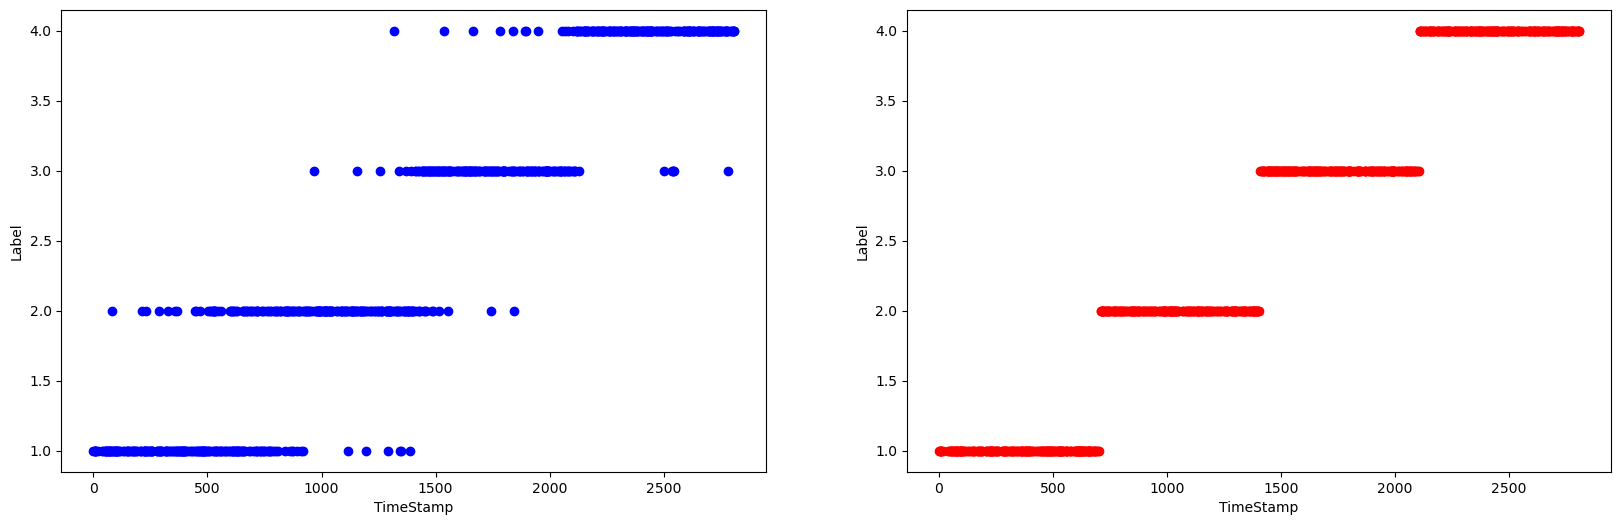

In [26]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
y_pred = model.predict(X_test)

fig,ax = plt.subplots(1,2, figsize=(20, 6))
ax[0].scatter(x = X_test.index , y = y_pred,color = 'blue')
ax[1].scatter(x = X_test.index , y = y_test,color = 'red')
ax[0].set_xlabel('TimeStamp')
ax[0].set_ylabel('Label')
ax[1].set_xlabel('TimeStamp')
ax[1].set_ylabel('Label')
plt.show()


In [ ]:
plt.scatter(raw_)

1. Change plot
2. Most contribute feature